# 第5章: 係り受け解析
夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [1]:
!head -n 24 ../data/neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.911675
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
* 2 -1D 0/0 0.000000
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ
。	記号,句点,*,*,*,*,。,。,。
EOS


In [2]:
from itertools import groupby

class Morph:

    def __init__(self, line):
        """
        Arguments
        line: str
            MeCabで形態素解析した一単語の結果。
            フォーマットは 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原型,読み,発音
        """
        surface, pos, pos1, _, _, _, _, base, *other = [line.split('\t')[0]] + line.split('\t')[1].rstrip('\n').split(',')
        self.__surface = surface
        self.__base = base
        self.__pos = pos
        self.__pos1 = pos1
    
    @property
    def surface(self):
        return self.__surface
    
    @property
    def base(self):
        return self.__base
    
    @property
    def pos(self):
        return self.__pos

    @property
    def pos1(self):
        return self.__pos1
    
    def __str__(self):
        return str({'表層形':self.__surface, '原型':self.__base, '品詞':self.__pos, '品詞細分類1':self.__pos1})
    
def gen_morph_of_sentence(): 
    with open('../data/neko.txt.cabocha') as f:
        morph_of_sentense = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    yield morph_of_sentense
                    morph_of_sentense = []
            else:
                for is_start_of_chunk, morphs_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                    if not is_start_of_chunk:
                        morph_of_sentense += [ Morph(morph_info) for morph_info in morphs_info ]

for i, morph_of_sentence in enumerate(gen_morph_of_sentence()):
    if i== 2:
        for morph in morph_of_sentence:
            print(morph)    

{'表層形': '\u3000', '原型': '\u3000', '品詞': '記号', '品詞細分類1': '空白'}
{'表層形': '吾輩', '原型': '吾輩', '品詞': '名詞', '品詞細分類1': '代名詞'}
{'表層形': 'は', '原型': 'は', '品詞': '助詞', '品詞細分類1': '係助詞'}
{'表層形': '猫', '原型': '猫', '品詞': '名詞', '品詞細分類1': '一般'}
{'表層形': 'で', '原型': 'だ', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': 'ある', '原型': 'ある', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': '。', '原型': '。', '品詞': '記号', '品詞細分類1': '句点'}


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
from itertools import groupby

class Chunk:
    
    def __init__(self, dependency_info, morphs_info):
        _, chunk_id, dst, *other = dependency_info.split(' ')
        self.__chunk_id = int(chunk_id)
        self.__dst = int(dst.rstrip('D'))
        self.__morphs = [ Morph(morph_info) for morph_info in morphs_info ]
        self.__srcs = []
    
    @property
    def chunk_id(self):
        return self.__chunk_id
    
    @property
    def dst(self):
        if self.__dst == -1:
            return None
        return self.__dst

    @property
    def srcs(self):
        return self.__srcs
    
    def add_src(self, src_index):
        self.__srcs.append(src_index)

    def get_surface(self):
        return ''.join(morph.surface for morph in self.__morphs)
    
    # for knock_42
    def get_surface_except_punctuation(self):
        return ''.join(morph.surface for morph in self.__morphs if morph.pos != '記号')    
    
    # for knock_43
    def has_noun(self):
        for morph in self.__morphs:
            if morph.pos == '名詞':
                return True
        return False
    
    # for knock_43
    def has_verb(self):
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return True
        return False
    
    # for knock_45
    def get_first_verb(self):
        # 最左の動詞の基本形を取得する
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return morph.base
        return None
    
    # for knock_45
    def get_last_particle(self):
        # 最右の助詞の表層形を取得する
        for morph in reversed(self.__morphs):
            if morph.pos == '助詞':
                return morph.surface
        return None
    
    # for knock_47
    def get_sahen_noun_and_wo(self):
        for i, morph in reversed(list(enumerate(self.__morphs))):
            if morph.pos == '助詞' and morph.surface == 'を':
                if i != 0 and self.__morphs[i-1].pos == '名詞' and self.__morphs[i-1].pos1 == 'サ変接続':
                    return self.__morphs[i-1].surface + morph.surface
        return None
        
    def __str__(self):
        msg = str(self.chunk_id) + ' '
        msg += self.get_surface()
        msg += '\tdst：' + str(self.dst)
        return msg
    

def gen_chunks_in_sentence():
    with open('../data/neko.txt.cabocha') as f:
        chunks_in_a_sentence = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst is not None:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
            else:
                dependency_info = None
                for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                    if is_start_of_chunk:
                        dependency_info = list(chunk_info)[0]
                    else:
                        morphs_info = list(chunk_info)
                        chunk = Chunk(dependency_info, morphs_info)
                        chunks_in_a_sentence.append(chunk)
            
for i, chunks_in_sentence in enumerate(gen_chunks_in_sentence()):
    if i == 7:
        for chunk in chunks_in_sentence:
            print(chunk)

0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [4]:
from itertools import islice

def knock_42():
    for chunks_in_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_sentence:
            dst = chunk.dst
            if dst is None:
                continue
            src_surface = chunk.get_surface_except_punctuation()
            dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
            if src_surface != '' and dst_surface != '':
                yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_42(), 30):
    print(chunk)               

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [5]:
from itertools import islice

def knock_43():
    for chunks_in_sentence in gen_chunks_in_sentence():      
        for chunk in chunks_in_sentence:
                dst = chunk.dst
                if dst is not None and chunk.has_noun() and chunks_in_sentence[dst].has_verb():
                    src_surface = chunk.get_surface_except_punctuation()
                    dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
                    if src_surface != '' and dst_surface != '':
                        yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_43(), 30):
    print(chunk)     

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
一度も	出会わした
真中が	突起している
中から	吹く
ぷうぷうと煙を	吹く
咽せぽくて	弱った
人間の	飲む


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

吾輩はここで始めて人間というものを見た。
0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


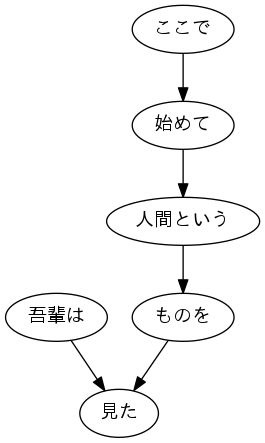

In [6]:
import subprocess
import pydot
from IPython.display import Image, display
                        
def knock_44():
    INPUT_FILE_PATH = '../data/knock_44_input.txt'
    OUTPUT_FILE_PATH = '../data/knock_44_output.txt'

    def gen_chunks_in_file():
        with open(OUTPUT_FILE_PATH) as f:
            chunks_in_a_sentence = []
            for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
                if is_eos:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst is not None:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
                else:
                    dependency_info = None
                    for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                        if is_start_of_chunk:
                            dependency_info = list(chunk_info)[0]
                        else:
                            morphs_info = list(chunk_info)
                            chunk = Chunk(dependency_info, morphs_info)
                            chunks_in_a_sentence.append(chunk)
    
    def write_dependency_to_file(text):
        CMD_CAT = 'cat %s' % INPUT_FILE_PATH
        CMD_CABOCHA = 'cabocha -f1 -o %s' % OUTPUT_FILE_PATH
        
        with open(INPUT_FILE_PATH, "w") as f:
            f.write(text)
        ps = subprocess.Popen(CMD_CAT.split(' '), stdout=subprocess.PIPE)
        subprocess.check_call(CMD_CABOCHA.split(' '), stdin=ps.stdout)
        ps.wait()
        
    def to_pydot_node(chunk):
        surface = chunk.get_surface_except_punctuation()
        if surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        return pydot.Node(chunk.chunk_id, label=surface)
    
    def to_pydot_edge(src_chunk, dst_chunk):
        src_surface = src_chunk.get_surface_except_punctuation()
        dst_surface = dst_chunk.get_surface_except_punctuation()
        if src_surface == '' or dst_surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        return graph.add_edge(pydot.Edge(src_chunk.chunk_id, dst_chunk.chunk_id))
    
    text = input()
    write_dependency_to_file(text)
    graph = pydot.Dot(graph_type='digraph')
    for chunks in gen_chunks_in_file():
        for chunk in chunks:
            print(chunk)
            
            node = to_pydot_node(chunk)
            if not node:
                continue
            graph.add_node(node)
                
            dst = chunk.dst
            if not dst:
                continue
            edge = to_pydot_edge(chunk, chunks[dst])
            if not edge:
                continue
            graph.add_edge(edge)
            
    plt = Image(graph.create_png())
    display(plt)

knock_44()

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で
    見る    は を
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [7]:
def knock_45():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                for src in chunk.srcs:
                    src_particle = chunks_in_a_sentence[src].get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                if len(srcs_particles) == 0:
                    continue
                yield '%s\t%s' % (chunk.get_first_verb(), ' '.join(sorted(srcs_particles)))

with open('../data/knock_45.txt', mode='w') as f:
    for s in knock_45():
        print(s)
        f.write(s + '\n')

生れる	で
つく	か が
泣く	で
する	て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て
思う	から
載せる	に
持ち上げる	て と
ある	が
落ちつく	で
見る	て を
見る	の
思う	と
残る	が でも
する	をもって
する	が
逢う	も
出会う	も
する	が
吹く	から を
弱る	て
飲む	の
知る	は
坐る	で に
おる	て
する	が で と
動く	が
動く	か が
分る	か
廻る	が が
なる	が
思う	と
する	が と
出る	から が て と
する	は
分る	が は も やら
付く	が
見る	て
いる	と は
見える	が も
隠す	さえ を
違う	は
明く	を
見る	て
棄てる	から に は へ
這い出す	で を
ある	が と に
坐る	に
する	て
考える	と
見る	て は
出る	も
泣く	て
来る	が に
考え付く	と
やる	に
見る	て
来る	が も
渡る	が と を
かかる	が て
減る	が に
出る	が も
ある	の
ある	まで
する	と を
そる	て
廻る	に も を
する	を
這う	て に
出る	で と へ
這入る	へ
思う	と
崩れる	の
もぐり込む	から て に
破れる	が
する	て に は
云う	は
至る	に
する	が まで を
なる	に は
忍び込む	は
分る	か ものの
なる	に
減る	は
降る	が
出来る	が で
あるく	と へ
考える	から
這入る	に
おる	て と は
見る	を
する	で に は
逢う	に
見る	で より を
つかむ	を
抛り出す	で は へ や
思う	と
ねぶる	を
任せる	から て に を
出来る	が は
見る	を
這う	て は へ
這う	は は
投げ出す	は
繰り返す	でも を
する	を
云う	と に
なる	は
する	を んで
下りる	から が
つまみ出す	が に
いう	と
出る	が ながら に
ぶら下げる	を
向ける	へ
出す	が
出す	て て も
上る	へ
困る	て は も
いう	と
撚る	を
眺める	ながら を
おる	て は
置く	へ
這入る	が といった へ
聞く	を
見える	と は
抛り出す	に は へ を
極める	と を
する	に は
合せる	と に を
帰る	から
這入る	に
出る	と
思う	と
いう	が
覗く	に を
見る	て は
する	を
ある	が が は


云う	と
出掛ける	まで
揉む	て
見る	から て
揉む	を
する	とか ば を
する	が
いう	とか ば
やる	て は は を
かかる	に
する	が が て
する	で
する	て に ので
食う	は を
いう	と
飲む	ばかり
暮す	で
見る	て
ぼる	ど
ぼる	ど
する	が と
出る	て も
思う	に
眠れる	が て は
する	で
する	て を
なる	が ば
やる	に
いう	と
やる	も
困る	が
かかる	に
する	に は
立つ	ものの
忘れる	と
する	と
なる	が に
読む	て を
かく	と も を
出来る	も
見る	が を
つく	の
止す	し
冷かす	と
する	から て は
食う	を
云う	と は
食う	から を
下る	が
直す	を
出来る	に
講じる	を
見る	て
傾ける	と
ある	が は
飲む	ずつ
する	に は
続く	も
する	は
やる	を
する	の も
する	で を
する	に を
尋ねる	が で
ほかなる	から て に は
云う	と
する	を
見える	と
する	を
苦しむ	が で
する	を
保つ	て を
思う	と
見える	と
云う	から と
する	から を
なれる	が だって は
極め付ける	と は
する	と ので は
富む	に の
見える	と
始める	から て を
見る	て
食う	を
ひっくり返す	を
知れる	と も
食う	が
見る	て も
ある	は
食う	が は
する	に まで を
食う	の
食う	も
なめる	し も
やる	ばかり を
ある	が が
見る	て
食える	は
云う	と
いる	で に
する	に
話す	の
よる	に
ある	が と に
尽す	に を
書く	が の
つける	を
思う	と
見る	て て
気に入る	が も
来る	が に へ
出掛ける	に に ので
知る	も より
連れ出す	に は
する	て の
出る	へ
する	と も
見る	で ばかり
いる	から が て
連れる	を
あるく	て
わかる	が
くう	に は
する	から は まで を
つく	が に に は
かく	が と に
限る	って に は を
つける	を
出来る	が
いく	は
作る	で
つける	は
ある	が
気に入る	で
出来る	が
忘れる	と は
がる	て
いう	と
つける	を
する	に を
かかる	の
出来る	くらい も
持つ	に を
出る	が は は
いう	でも
なる	に
し

する	が で を
引く	て へ
握る	を
咽ぶ	て と は
なる	で に
笑う	て に は
いう	と
云う	と ながら は
叩く	が で と を
なる	に
離れる	から は を
する	を
出る	が
する	を
やる	て でも は を
願う	から も を
やる	も を
聞く	と
撰ぶ	を
する	で に は
云う	と
当る	が にゃ
聞く	と
する	て
思う	と は
する	が と を
とる	と に は を
留める	も
云う	と
笑う	で と は
云う	が と
云う	と
解す	は を
する	を
しつける	て
する	から が は も を
聞く	が と に
見る	を
買う	が に に
挿す	て は
持つ	が
ねじ伏せる	て と に は を
いう	と
する	に は ば を
廻る	が と の の を
聞かす	か
見捨てる	に を
つく	と は を
聞く	を
する	と
伺う	から を
願う	から を
云う	と
ある	が
待つ	から に
来る	と ので
食う	を
読む	て で を
来る	から が へ
見る	から
いる	に
思う	と に も を
する	を
焚く	を
する	て に を
引く	と を
ある	が が とか
いく	は は
する	と に は も
つける	に
する	か
揚げる	て を
なる	は
生きる	の
する	に を
知る	て に を
云う	と
なる	に
始まる	が
する	を
いる	て て に は
遊ぶ	に に のに も
書く	と
思う	の
遊ぶ	でも に は
来る	へ
出る	で に
する	だり て て
する	が ね ものの
読む	を
なる	が
つまる	て は も
云う	と
起る	が
取る	しも
候う	に
祝う	を
書く	が と
する	が
来る	が て
思う	と んで
来る	が
なる	に
書く	から へ も
思う	と
かく	て と
ある	は も
出来る	が は は
蒙る	で でも
ある	から に
来る	が
云う	と
なる	に
入れる	を
出掛ける	て ながら に
思う	と
向く	が
出る	で は へ
曇る	は
向う	から が の
吹き付ける	から
鳴る	から が と
通り過ぎる	て を
する	が
云う	と
廻る	が け を
云う	が と を
誘う	に
死ぬ	て
なる	が に
思い出す	と
上げる	と を
見る	て を
来る	と に
投げ入れる	が と を
縮める	と は を
ひろげ

する	で でも を
云う	とか
やる	を
聴く	から に
云う	と
聞かす	も
云う	から と
呼ぶ	へ
する	に
ある	なんぞ
聞く	じゃ
呑み込む	で と は
分る	なんか にゃ
憤る	を
云う	と に は
付ける	が
云う	と
云う	と
ある	から が
する	から は
する	が で
聞く	から
云う	と
叩く	と の を
笑う	と
顧みる	を
退く	て ながら は へ
撫でる	は を
撫でる	は
来る	が と
する	に は を
いう	と
着る	を
聳やかす	て を
上げる	て を
落ちつく	て と
する	て ので を
待つ	から で に
見る	と を
する	と も を
いそぐ	は
する	へ を
云う	と
やる	に よー
なさる	か は
騒ぎ立てる	で と は
取り出す	から を
願う	から を
する	て と に を
浚う	の
始める	て は を
絞る	を
処する	に
云う	と
行う	に に
溯る	に より
考える	て
行う	として に
在る	に
抛る	を を
殺す	て
する	を
見る	て
釣る	を
する	て と
認める	と と は
見る	に従って
去る	を
曝す	から を
忌み嫌う	を
思う	と に は
斬る	を
する	て に に を
する	て に は
なる	が
入れる	が と を
這入る	に
願う	から を
申す	と
用いる	と は も を
致す	に に
打つ	から を
分る	か は
いう	でも は
する	と に は を
らっしゃる	が
聞く	が より
する	が を
する	と と と は を
入る	に
弁じる	て
使う	を
貰う	て は
交ぜ返す	と
云う	が と
問いかける	で と は
聴く	は
交ぜ返す	か
する	か
構う	に
切り抜ける	と は を
弁じる	て
云う	と は を
吹き出す	は
用いる	として を
調べる	の
まする	により
出る	と に は
する	が を
する	で を
なる	も
致す	から が に
なる	から に を
分る	と
出来る	が
云う	と
する	と に は
読める	が は
致す	に
弁じる	て は を
する	から を
見る	て
する	を
ある	が と に
括る	が て は へ を
開ける	に へ を
入れる	ずつ て へ を
引張る	を
する	て て
見る	と
ぶる	が に
見る	と
括る	へ を
釣る	から て で は へ 

知る	ね
食わせる	と は を
ある	が で
利かす	を
直す	て と は を
知る	も
する	が を
する	わ を
する	が て に は
結う	に
する	て と は を
食わす	から と を
掛ける	て を
いただく	から
思う	と
しまう	か て へ
汚れる	が
かける	から
える	が
上げる	を
ある	が
いらっしゃる	へ
染め出す	て ので へ を
上げる	から に
おっしゃる	と
恐れ入る	わ
だまる	を
貰う	て よ
似合う	くらい さえ
遊ばす	か
分る	が
黙る	に
掛ける	て
する	は
する	は
する	と
呼ぶ	が で で と を
出る	と は を
引く	が に より を
する	を
付く	て
出る	から で へ
帰る	て で に は
見る	て
移る	と へ
入り込む	から へ
する	が ので
奪う	に を
留る	は も
感ずる	を
なる	が が と は
思う	に
思う	と も
立てる	に を
見る	て て
ある	から が
這入る	へ
見る	て
驚く	と
帰る	は
突き立てる	の へ を
話す	か て で
来る	さえ
する	を
洩る	の
眺める	て は を
言う	まで を
かい出す	から と
する	を
差支える	も
なる	の
する	に を
する	を
云う	と
ひねくる	と の は を
ある	に
寝る	が と
云う	ながら
付く	に の
着る	でも
付く	の
する	が を
結う	に を
云う	と
用いる	が に は
する	に も
する	が で を
致す	に
似合う	が
云う	と
ある	も
云う	から が ので を
打つ	を
出す	と ながら は を
見る	て なあ
呼ぶ	から を
着る	を
極め込む	て を
飛び出す	から が と は
呼ぶ	から へ
おりる	は
する	と は を
押しかける	が
驚く	は へ よ
飲む	と ながら は を
聞く	を
来る	が に
する	が と に
がる	か
がる	か
窺う	と を
見る	て
貰う	に を
云う	と
ひねくる	で と を
言う	が ね
考える	から について は を
接ぐ	に を
云う	が と と を
笑う	が で
云う	が と に
おる	て
笑う	が と
付ける	と へ
出来る	と は
見える	も
いける	は
並べる	が と を
云う	で と
する	が と に
いる	も
すかす	から
見る	て て を


知れる	だって
云う	から と
知れる	が ちゃ
云う	と
見る	が
釣り合う	から って
する	が を
揉む	が くらい を
ある	が に
つける	を
与える	て と は を
出来る	が は も
する	ので
する	に
喰う	と を
ある	が が
進める	から を
する	を
心付く	が て と
云う	で
いる	は は も
する	に
云う	と
なる	に
威張る	なんて
する	じゃ
いく	から ちゃ と
来る	の
いる	が
云う	て ばかり
いる	と も を
なる	が でも
対す	へ も
ある	が
云う	と
する	も
受ける	て を
行く	ね は は
いる	だけ も
云う	と
ある	が さ
行く	ね も
見る	て
する	で を
思う	と に も
思う	に
してやる	に ば
活かす	を
殺す	も
来る	が
かく	を
勧める	から
見る	じゃ て に
貰う	が を
見る	か て
する	を
纏まる	が て
引く	に を
見る	て
引く	を
見る	て
引く	を
云う	と
ある	が と
知れる	かも
引く	を
する	を
分る	と
分る	にゃ
知れる	かも
聞く	と にゃ
分る	が は
入れる	に を
打つ	て
思う	と
する	に
来る	が
する	を
給う	て
かかる	に
助かる	と
きく	と に を
する	を
洩れる	に
乗じる	から に の
舞い込む	て と ば
なる	に
したがう	に
いく	て と は
くる	くらい
限る	でも に は
頬張る	と に を
する	は
する	は
もぐ	が は
する	から を
云う	て と
する	は
思う	と は
やる	で を
明く	も
思う	と
する	は
廻る	に
限る	も
云う	と に対する も
知る	と は を
逢う	も も
おける	の
限る	に
見える	て も
つく	か が が は
する	に
する	と は は
いじる	が て に を
乗る	へ
発する	と に対して は を
ひやかす	から
来る	に
持つ	だって でも を
出来る	に
持つ	は
喰う	が に
出る	が へ
喰う	の
やる	ばかり を
する	が ば を
持つ	は
なる	として は よ
持つ	だって も
建つ	が くらい
行く	へ
云う	と
考える	に ば
つまむ	を
見る	で を
する	が も
出る	が て と と へ
有す	から が は を
構う	でも は
乗る	から が へ

する	は
聞く	と に
見る	て
食う	が
有る	も
食う	が
釣る	で
禿げる	から は
云う	で を
云う	とか は
ある	が
聞く	に
教える	は
聞く	から に
知る	は より
云う	と
云う	と
云う	が と
知れる	も
行く	へ
引く	て を
調べる	て
変る	も
する	に
出掛ける	に も
連れ出す	が
云う	の
舐める	でも を
舐める	の
云う	と
困る	て
云う	か と
舐める	に
云う	だって を
する	だって を
分る	が で
舐める	が じゃ も
舐める	は
好く	って
思う	と
持つ	ばかり
困る	ばかり
取る	が を
する	を
する	に を
飼う	か を
いる	は
食う	ば を
捕る	で は も
とる	も
ある	は
なる	も
貰う	が
行く	て
煮る	て
食う	て
知る	か
食べる	は を
食う	を
ある	が は
する	て は
知る	が が が は まで も も
係わる	も
見る	を
思う	と
云う	と
証拠立てる	によって は
見る	を
思う	と
する	によって
知る	ば を
知る	を
なる	が て
なる	も
着ける	も を
知る	を
知る	て を
取る	を
いる	が に
する	で と共に に
知れる	かも が な は
考える	と
なる	て に
する	と を
引き上げる	て へ
聞きつける	を
出る	て と は へ
逢う	に
やり込める	と に
もつ	を
する	て と は も
取る	が も
取る	も
持つ	が と は を
来る	が
する	は も を
くむ	に を
立つ	ちゃ も
する	に
聞く	を
洩らす	て と は を
する	が も
食う	も
云う	も
転じる	は を
とる	を
重ねる	は を
する	から も
する	だけ
働く	に
する	から て は は も
する	を
逢う	に
困る	も
換える	から を
なさる	て でも
言う	を
する	から が と に を
なる	に
貰う	て は
する	を
なる	て に
顧みる	と は を
云う	とも も
上がる	は も
褒める	は も
覚える	で と
する	に を
する	から と を
考える	か で と は
似合う	に
云う	と を
向く	を
見る	が を
凹ます	と を
云う	で
はおる	て
する	と を
なさる	で に
壊す	を
なる	に
儲ける	なんか
する	も
這入る	へ
ある	が よ

言う	の
なる	から も
うかがう	を
ある	は
する	と も を
云う	は
云う	と な
振る	は
する	でも に へ
云う	の
取り合う	は
折れる	の
聞く	で と に は
する	も
こしらえる	を
やる	から が て
思う	と
行く	へ
なる	と に
云う	とか
合う	に
出す	が と を
作る	を
見る	て
思う	と
やる	から
きく	が と に
云う	が と
気が付く	と は
見える	と
過ぎる	が て
思う	と
落す	て を
なる	が と は
折る	を
磨り潰す	て を
思う	と
なる	が と
取る	で を
出来る	が と に
なる	が
なる	て に は
なる	と に
なる	に
出来る	は も
磨る	に も
磨り潰す	から が を
つく	か の
述べる	と と を
磨る	で
なる	から
磨る	て で まで
しいる	が が じゃ
しく	が
云う	と
行く	じゃ て でも へ
磨る	を
行く	に は
磨る	から は ばかり まで
なる	と
入り込む	て
云う	と
聞く	を
ありがたがる	は も
ある	が
ある	が
行く	へ
出る	て て に を
出逢う	と に
向く	が が に
思う	と
する	て に
云う	と
する	を
読む	を
来る	て に
通り掛る	を
する	が
立ち寄る	から じゃ に
云う	と
する	を んで
入れる	が として に は
つける	と の を
磨る	ばかり
聞く	て と は
かかる	くらい じゃ
見受ける	と に は より
磨る	じゃ
よる	に
かかる	くらい と
なる	も
してやる	て
磨る	を
出来る	が が ちゃ
切る	を
及ぶ	て は は
磨る	でも ばかり
する	は
話す	も を
する	と
述べる	たり に
分る	まで を
する	ながら
残る	は
行く	から へ
尋ねる	が と に
する	な
とぼける	が と
途切れる	の
飛び出す	から でも
行く	へ
逢う	で に
云う	は
起る	が
する	に
思う	も
する	に に も
片付く	へ
解す	を
なる	て に
おっしゃる	が に を を
切り付ける	から と に に は
する	だって
する	から と に も を
する	は も
残る	から は
なる	に
暮らす	が で でも まで
見廻る	に を
わする	と
云う	と
いる	て
向く	で と を
伺う	に を
する	と は


する	から を
待ち構える	を
見える	て
いる	で
ならぶ	が に は も
参る	から と と
参る	だけ
ある	の
向う	に を
やる	が を
云う	と
張り付ける	て と ほど
する	が に
廻る	から と の を
逃げ延びる	しか
おる	て は
知る	を
する	から を
逃げ惑う	へ
追っかける	へ も
がる	は
振る	を
試みる	て て を
ある	から が は
する	と
見る	て
なる	が の は
する	を
試みる	て を
ある	の
引きずる	を
あるく	て は
云う	と
過ぎる	が に
ある	と は
抜ける	け て へ
出来る	が で
する	から は
なぐりつける	を
広げる	を
れる	は
抑える	で を
する	て
抑える	て
攻める	で
繰り返す	を
出来る	て も
見る	を
振る	へ
見る	て て
寝る	は へ
付く	から で
飛び上がる	で
抑える	て を
なる	も
食う	から として
食う	を
話す	に
云う	と
やる	を
云う	と
ある	が も
みる	も
ある	が
行く	て は
困る	は
つく	は
なる	に は
出る	と
綻びる	の
断わる	から が
撫でる	に を
引く	を
云う	と
立てる	に
見る	から で
鳴く	と
とる	と に
思う	と
取る	は を
称す	を
云う	て と
話す	に
つく	と の
転がる	に
はおる	が て は
落ちる	に
つく	が は
取る	の
寝転ぶ	に
とまる	に
いつく	て
鳴く	と
捕える	を
聞く	から に
つく	は
鳴く	と
鳴く	か が と
ある	か が は
思う	と
優る	に
存する	に は
ある	に ので
出来る	が
する	に は
しる	を
上る	に を
行く	て
なる	が
鳴く	て て
捕える	を
見える	に
折れる	て の
有す	を
行く	から を
劣る	は
思う	は は は
する	から
見る	て
負ける	て は
至る	に
いる	が は より
侮る	も
いる	が として は
逆らう	が に
出来る	から
思う	は も
与える	けれども は を
云う	と に
ある	が
する	か は
見る	で
ござる	ので は ほど ものの
違う	と
飛ぶ	て
云う	と
する	に
限る	が も
かける	から に を
ある	が
する	が を
垂れる	か は
致す	から に
仕る	に を
及ぼす	に
しる	か
出る	

する	に
なる	が て に は
思う	と
思う	と
見る	て
答える	で と
ある	が と
そらす	と に を
出来る	として も
砕ける	が の
投げ入れる	と に に を
見える	が と
くぐる	を
鳴る	と
なる	が が て に
ある	に
燃える	を通して
飛び下りる	から から
帰る	て に は
考える	も
脱ぐ	を
脱ぐ	を
脱ぐ	を
なる	で に
力む	と
出る	が は
する	て を
なる	に
得る	たって
見る	て
光らす	を
食う	て は を
上がる	から が
見る	を
あるく	を
云う	て と なあ
見る	を
ならべる	と に を
焼く	に の
ある	が
知る	か は
やる	で
する	と は
焼く	でも
煮る	たり
たまる	が は
する	に
保つ	て を
坐る	て に
ある	が
する	か て
装う	と
知る	を
食える	は は
諦める	と
突っつく	は を
云う	と
する	を
置く	が て を
控える	に
する	に
する	に は を
撲る	を
見る	て
する	と に は
する	ば
見る	から て
敲く	で と は を
見る	て
参る	で と と
する	から
する	と は は
出来る	が
見る	が て ば
困る	から も
困る	し も
ならぶ	に は まで
ぶつ	に
見る	て
云う	で と ので
なさる	て に
問う	で と
なる	と ながら に は
わかる	が
する	ば を
出来る	は
なる	から は
云う	と
返る	も
する	は ば も
すむ	も
なる	で に
繰る	も も を
見る	て
云う	と
する	と を
する	から を
懸る	て
打つ	て
云う	と
含まる	さえ
考える	に に
重んずる	を
云う	と
する	を
嫌う	の
誇る	て
出る	に は
足りる	の
湧く	から
する	と
食う	を
張る	が ば
極まる	に
出る	が ば
く	に
死ぬ	ば
極まる	に
打つ	から
鳴く	ば
やる	と に を
合う	が に
行く	で
落ちる	と へ
死ぬ	ば
なる	に
食う	を
する	ば
なる	に
もらう	を
する	ば
なる	に
読む	を
なる	ば
なる	に
出来る	が は
なく	ば
見る	に
生れる	と
凹ます	だけ で を
しかる	て
鳴く	と にゃ
向う	に
云う	と
知る	か か は
聞く	て と は
云う	ので も
云う	を
さめる	が
思う

禿げる	が
打ち出す	から しも
通り越す	を
振い落す	て を
する	て に は
うる	を
ある	に に
もつ	を
動く	て に
する	と ば
せる	が によって
する	に は ば を
する	に
する	て と は も を
取りとめる	に ので は を
する	に
働く	の
起る	において
する	と に は
わかる	か は
突き通す	が を
裂く	を
する	て て を
もつ	を
見る	て
乗り込む	に
覚す	と の
もつ	で と
敲く	て を
する	が と
乗り込む	が へ
拾う	で を
出す	は を
拾う	て
達する	が は
知れる	は
からかう	に
する	から は は
中る	に
知る	も
分る	も
心得る	て も
拾う	て
拾える	ば
よる	に
ほる	に
あらわれる	でも に は
いる	が は
知れる	かも に は
抛る	に を
映ずる	に
慣れる	に は
分る	ば
かく	を
挑む	に に を
する	ども は
きく	から を
する	て
立ち上がる	として は
出す	け として
捕る	として を
する	に
生える	の
思う	と
引っ張る	に を
連れる	て まで
する	に について
ある	が
見る	が を
する	で
察す	て と は は
まつ	て
なる	は
拾う	を
やる	に
避ける	を
越す	か て に
つる	が を
捏ねる	て を
する	は
する	に を
なる	って に
云う	が と
入れる	に を
忘れる	は を
ある	が に
飛び出す	だって ば
釣る	に を
上げる	し
ある	の
与える	て に は を
ある	の
誇る	に を以て
足る	に は
なる	に
捕る	を
する	て と
出来る	の は は
勤める	によって を
追い詰める	に
ある	て も
引く	こそ に
見る	を
行く	と に は
乗る	を
乱れる	から て に も
並ぶ	に は ばかり
つける	は も
まくる	を
する	て を
ある	が
乗せる	に へ を
ある	が
思う	と
とる	に を
縫いつける	て に に を
ある	と も
見える	と も
着る	から
云う	て と は
する	が に
入れる	へ
する	て を
する	か に
なる	に
思う	と
申し合せる	は
まくる	に を
行く	でも
見える	て に
ならぶ	に
発する	として は も
開く	も を
する	を
ある	が に
する	と は

する	として を
見る	から
恐れ入る	が と
下げる	て を
なる	に は も
見る	を
悟る	て を
印せる	に
読む	に
する	を
する	を
なる	は も
やり込める	から も
考える	に
うかがう	ながら を
知る	も
する	を
する	で と は
言う	と
する	で
こする	ながら を
なる	さえ
擦る	を
たまる	けれども は
する	に の
きまる	に
開く	を
向う	て に
見る	を
曇る	と として に
する	から
用いる	を
する	が として
する	くらい と
する	が として に
漂う	て として に に も
云う	も
する	も
なる	の
ある	て は は も
生れる	まで
する	が こそ で に も
思う	に
かよう	が
する	に に
直す	も
する	から が
達す	が て に
あらわれる	から が と に
いる	に
掛ける	て は を
知る	て を
証す	て を
見る	て
あく	が の は
する	に
ねじる	は を
とる	を
生える	から て で
流行る	が
尽くす	に を
思いやる	と
鑑みる	に も
与える	て に は を
出来る	て
する	に
する	に
ととのう	が て は
生える	が
おる	て は
生やす	は を
する	と
なる	が に
応じる	に
する	て
見る	と
すく	が
おる	て
向う	に
加える	から て て は ば を
蓄える	を
ある	に に は
からげる	と
握る	に
引っ張る	とも は へ
ある	すら も
扱く	で に も
見る	から
知れる	の
心得る	が と は
撓める	が に を
見る	て を
誇る	と
する	で
もつ	を
する	が て を
参る	から が が と
出す	と の へ を
つかむ	に を
持つ	に を
振る	は を
命じる	か に を
見る	を
引き戻す	へ
もたす	へ を
笑う	て て は や
おろす	と を
取り上げる	て を
並べる	が で は
見る	で
乗じる	に
告げる	て を
奏す	に を
若く	か に
奉じる	に に
在る	に
く	て
忍ぶ	を
する	に
捧げる	に を
する	て なり
告げる	を を以て ん
する	と
期す	を
する	に対し を
する	て を
する	て て は を
迎える	を
表す	を
仰ぐ	を
する	を
得	を
ある	て
堪える	に を
ある	と
巻く	へ
する	て

とる	を
進む	て も
分る	が
掛ける	が と に を
さめる	が
寝る	か
なる	に
する	か は も
する	を
切る	を
云う	は
出る	は も
なる	が も
なる	くらい
ある	が と
限る	に
好く	て に
おる	すら て
云う	と
見離す	に
持てる	さえ
気に入る	に
する	に を
する	において を
好く	て で に
つける	と を
なる	も
申す	から から が と と
くる	が に
する	と
する	が に を
むく	を
発する	さえ
ある	に
ある	て に は
する	と
知る	も
云う	と
担ぐ	で を
行く	て で は は は へ も
叩く	を
する	が
始める	によって は を
帯びる	を
する	か の
する	を
差し支える	ば
至る	に
云う	から と ものの
云う	と
する	と に は を
かける	へ を
滑る	て へ を
する	と
至る	に
背負う	だに
おる	て は
ある	の
いる	って
溜る	が でも
いる	が が て は
云う	と
ある	も
知れる	から は も
なる	は も
やる	も を
かたちづくる	を
結びつける	て で
至る	の
生れる	が
する	が
おる	て の の は も
かかわる	に の
違う	と は
なる	から に
向う	さえ に
もつ	を
有る	て に
立つ	の
立ち上る	から が が で に
する	は
思う	と
する	が と
知る	と
する	ながら に を
描く	に を
落ちつく	て に
行く	は
合う	か が
する	か とも
見る	が て
見る	て
きまる	に ば
受取る	に を
這出る	て は へ
ある	に
覗く	を
見る	て
違う	と に
洩る	が を
かがやく	として に
移す	に を
かける	て に
かきまぜる	は を
流れる	て
こびりつく	が
貼る	を
見える	て に は は
出来る	も
食わせる	から
思う	と
する	に
なる	に
行く	たって で は
してやる	て を
考える	と
甘える	に
見る	が が て
泣く	を
起す	て を
見る	に
帯びる	ながら を
する	て を
足る	て に は
信ずる	と
顧みる	として は
知れる	は
勤まる	が
ある	が
具える	て は を
云う	から
ある	が が
開ける	から も
云う	と
開ける	も
出す	に
思う	と
入れる	と は
立つ	に
待つ

なる	て に
いる	て は を
する	も
する	て を
貰う	から が を
する	を
出す	から に
分る	は
する	は を
見る	て も
観る	を
ある	が
見る	が
いる	の
行く	なんて へ
ある	が
行く	へ
足りる	が
戻る	で
する	に
云う	と
待つ	ながら まで
ある	が
いく	か から は
いける	が
する	を
いける	ちゃ って
知れる	が
なる	と に
思う	と
あきらめる	くらい
待たす	は も
潰す	て を
着る	と に
たれる	に も
眺める	て て を
諦める	と も
しまう	へ を
帰る	て で に
買う	で を
する	も
行く	へ
ある	だって も
云う	に を
いく	て は
読む	でも
ある	の
這入る	は も
這入る	へ
這入る	から
買う	か で
笑う	は
なる	は
生きる	は も
云う	から を
する	が
見る	て
感ずる	を
至る	に
這入る	から
買う	に を
ある	が
這入る	に
知れる	が
いる	が
云う	と
買う	に を
がる	が
廻す	から へ を
下す	か て
おきる	って
還す	ながら
云う	と
云う	から と
いる	は
いう	けれども
言う	を
云う	と
云う	と
ある	が のに
繰り返す	な ばかり
繰り返す	だって ばかり
繰り返す	が
云う	と
いる	は
教える	じゃ を
おっしゃる	から でも
還す	を
する	だって なんて は や
なさる	も
する	を
なさる	に に
云う	と
する	から
する	って て に は や
至る	に
堪える	て に
落す	として に は ものの を
する	が に
する	を
見つめる	として ものの を
揃える	から が に へ を
いらっしゃる	が
云う	て と
来る	が
聞く	が と
睨める	に を
答える	と と ながら は
出る	は へ
する	に
廻る	て に へ も
する	を
ある	か が
択ぶ	は を
出る	が と
聞く	も
なる	と
持ち上がる	が と に
云う	と と に
見る	から
なる	て に
至る	が ば
あらわれる	に に
有す	の を
する	と を
思う	も も
帰る	が
抛り出す	て を
する	として に に を
する	て
く	が やいなや を
あらわれる	に は
あらわれる	は
あらわれる	が として に の は
する	に
撫でる	に に を

ある	は
代る	が と に
取る	て を
する	に も
入る	が に
ある	が は は
する	を
する	は を
背く	に ば
思う	と
向き直る	で と は へ
這入る	に は
貰う	を
這入る	ば
する	を
云う	て と は
ふれる	に
する	て を
分かる	が は ば も
習う	でも に
思う	と
きく	から から て に を
する	を
する	は
収める	が と を
開ける	で は
知れる	が で
知る	を
思う	と
する	に を
蘇る	に
じみる	に
する	て を
知る	も
する	と
すむ	から が は
知れる	も
表わす	を
思う	が と
捨てる	を
参る	から は
行く	に
する	を
聞く	て
する	に
はじめる	を
する	から は ば も を
困る	に
ある	が に
ある	は
する	から も
溜める	て
差支える	から
買える	が
見つかる	から ば
云う	と ば
加える	ので を
加える	から を
表す	と に は を
蒙る	か は
する	ね を
ある	の
通る	て を
買える	が に
抱える	に を
思う	と
評す	と
凝る	に
解す	で と
する	で と
撚る	として は を
ある	が に
知れる	が
見る	て
云う	と
ある	が と も
する	て として は を
ある	は
云う	と
つく	が
おく	も を
吊るす	に ので へ
する	を
通る	て を
吹く	が に
障る	が たり
出す	て を
ある	が ね
聞く	を
する	が に
立つ	で も
ある	が も
ある	だけ は
冷やかす	が と
なれる	は ば
する	と は
知れる	かも
ひく	まで
出る	が が くらい
ある	が
する	さ と
鳴る	として
持ち出す	と を
取り合う	も
する	が を
きく	に を
ある	に
買う	は も
する	と
する	から
する	から も
する	に も
受ける	て を
いる	に は も
思う	と も
する	も
起す	を
見る	て て
心掛ける	と
いける	が
行く	へ
出来る	て
聞く	だけ に
乗る	が が に
がる	と は
話す	で
出来る	が
する	から
買う	て
行く	て に に は
いる	から も
云う	と は
休む	も
寝る	て で は
入れる	こそ て て に を
考える	で と ばかり
つかう	を
休む	て まで
恐れ入る	と も
出す	から 

見る	は
なる	は
なる	と に に
捧げる	と を
申し立てる	が に を
云う	と
至る	に
なる	て と は
悟る	と
云う	を
する	に
やる	か を
知れる	かも と は
進む	が で
行く	で
生きる	は や
いう	が と
いる	は
死ぬ	から
する	が と に
わかる	が
張る	と を
する	も
生れる	て は
有る	は
する	に は も
見える	が と
のべる	が と を
借りる	を
借りる	に は
する	は
出来る	と に の
返す	を
考える	を
する	に を
云う	に
悟る	が
云う	と に
ある	が さ
云う	と
する	に を
云う	と
する	が
見る	から
やる	が に
する	に を
述べる	て と は を
返す	を
済ます	に
ある	は
返す	は
聞く	から て
返す	を
済ます	に
済む	に
する	は
なる	が は
聞く	から て
なる	が
起る	が に
有す	と共に は を
出来る	が
する	に を
する	から に
死ぬ	は
する	と
足りる	が
する	から に
殺す	が に は
ある	と
殺す	から に
する	て
付く	に
する	を
する	が て は
もつ	を
去る	て を
なる	に
云う	と
かく	の
する	に を
ある	が
する	に
立つ	から も
云う	と
する	に より
考える	に は ば
なる	に
なる	よ
積む	が も
なる	で に
授ける	て で として に を
出る	な に
なる	に
なる	に
云う	と は
云う	と
する	を
する	が として に
こす	に
なる	て
する	を
する	て に
ござる	て は
見受ける	に
進ぜる	から て
違う	と
用いる	を
する	から て は を
なる	が
なる	によって も も
する	を
ある	が
する	が を
する	と は を
なる	に
もつ	を
する	て を
あるく	て と
する	から で
生きる	は
打ち殺す	から が に
利く	の
する	は
打殺す	に
限る	か から に は
する	は へ を
ある	とか
巡る	が とか に ば
取る	て
引く	が を
拾う	て
あるく	て は
出来る	が
ある	が は
する	と に は
する	に を
弁じる	ながら は
云う	と
云う	と
知れる	が ば
する	に
せる	に
する	て と を
云う	を
する	から と に
知る	を
恐

In [8]:
# コーパス中で頻出する述語と格パターンの組み合わせ
!cat ../data/knock_45.txt | LC_ALL=C sort | uniq -c | sort -nr

    704 云う	と
    452 する	を
    333 思う	と
    202 ある	が
    199 なる	に
    188 する	に
    175 見る	て
    159 する	と
    117 する	が
    113 する	に を
     98 見る	を
     97 見える	と
     90 する	て を
     85 する	は
     61 する	て
     60 する	が を
     60 する	も
     60 もつ	を
     57 ある	の
     56 云う	を
     52 行く	へ
     52 ある	も
     51 する	から
     51 する	と を
     50 云う	が と
     49 出来る	が
     47 ある	が は
     46 聞く	を
     46 する	で を
     45 なる	が に
     43 ある	は
     40 ある	に
     40 する	の
     39 ある	が に
     39 する	と は
     38 食う	を
     38 いう	と
     37 至る	に
     37 する	から を
     37 する	は を
     36 知る	わ
     36 する	で
     35 聞く	と
     32 来る	が
     32 する	が と
     32 する	が に
     32 やる	や
     32 よる	に
     31 持つ	も
     31 なる	と
     31 なる	は
     30 出る	が
     29 出す	を
     26 なる	て に
     25 帰る	な
     25 云う	とか
     25 する	と は を
     25 する	に は
     24 読む	を
     24 云う	から と
     24 云う	と は
     24 する	て に
     24 なる	に は
     24 いる	に
     24 とる	を
     24 なる	が
     23 見る	て て
     22 云う	て と
     22 云う	と に
     22 云う	と ば
     21 見る	て も
     21 行く	に
    

      4 追う	も
      4 述べる	と を
      4 述べる	を
      4 足りる	で
      4 起す	が を
      4 起る	は ば
      4 買う	に を
      4 貰う	は
      4 負ける	から
      4 読む	て
      4 読める	の
      4 話す	て
      4 評す	と
      4 訴える	に
      4 言う	が と
      4 言う	が
      4 解す	に を
      4 解す	を
      4 覚める	が て
      4 見廻す	と を
      4 見出す	も
      4 見る	から て て
      4 見る	が て
      4 見る	は
      4 見える	て
      4 見つめる	て を
      4 表す	の
      4 行く	が へ
      4 行く	で に
      4 行く	に も
      4 行く	は へ
      4 落ちる	て
      4 落ちる	と
      4 苦しむ	て
      4 舐める	に
      4 聴く	て
      4 聞く	から
      4 聞く	て と は
      4 聞く	と に は
      4 聞く	が を
      4 聞く	で を
      4 聞く	と に
      4 聞く	に は
      4 聞く	に も
      4 聞く	が
      4 聞える	が と
      4 聞かす	に
      4 罹る	に
      4 繰り返す	を
      4 縛する	に は
      4 答える	と に は
      4 立つ	が に
      4 立つ	が
      4 立つ	て
      4 立つ	で
      4 立てる	で を
      4 突く	で を
      4 積む	が に
      4 移す	に を
      4 禿げる	に
      4 知る	か が
      4 知る	と
      4 知れる	かも と は
      4 知れる	かも は
      4 知れる	が
      4 着る	に を
      4 着ける	て を
      4 直す	も
   

In [9]:
#「する」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^する' | LC_ALL=C sort | uniq -c | sort -nr

    452 する	を
    188 する	に
    159 する	と
    117 する	が
    113 する	に を
     90 する	て を
     85 する	は
     61 する	て
     60 する	が を
     60 する	も
     51 する	から
     51 する	と を
     46 する	で を
     40 する	の
     39 する	と は
     37 する	から を
     37 する	は を
     36 する	で
     32 する	が と
     32 する	が に
     25 する	と は を
     25 する	に は
     24 する	て に
     17 する	が に を
     16 する	から に
     15 する	て と
     15 する	は も
     14 する	ほど
     13 する	て は や
     13 する	に は も
     13 する	も を
     13 する	か
     12 する	て に を
     12 する	と に も
     12 する	て は
     12 する	ば
     11 する	が と を
     11 する	と に は
     11 する	が で
     11 する	が は
     11 する	で と
     11 する	に に
     11 する	に も
     10 する	から ね
     10 する	と に は は
     10 する	が で を
     10 する	が も
     10 する	と に
     10 する	と も
      9 する	から へ
      9 する	て と へ
      9 する	に に も
      9 する	で に
      8 する	まで も
      8 する	でも
      8 する	で に も
      8 する	ば も
      7 する	から が
      7 する	さえ
      7 する	て も
      7 する	へ
      6 する	くらい
      6 する	が て に
      6 する	が て は
      6 する	が て を
      6 する	て 

In [10]:
#「見る」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^見る' | LC_ALL=C sort | uniq -c | sort -nr

    175 見る	て
     98 見る	を
     23 見る	て て
     21 見る	て も
     20 見る	から
     17 見る	と
     13 見る	て は
     12 見る	から て
     12 見る	で
      9 見る	に
      8 見る	て て は
      8 見る	て と
      8 見る	が
      7 見る	が を
      7 見る	と へ
      7 見る	に を
      6 見る	て は を
      6 見る	は は
      6 見る	も
      5 見る	から て に
      5 見る	から に
      5 見る	か が
      5 見る	で を
      4 見る	から て て
      4 見る	が て
      4 見る	は
      3 見る	たり て
      3 見る	て ので
      3 見る	が て は
      3 見る	て ば
      3 見る	で で
      3 見る	ね
      2 見る	ながら に を
      2 見る	だけ も
      2 見る	て に は を
      2 見る	が て で
      2 見る	が で を
      2 見る	が は も
      2 見る	て て で
      2 見る	て で は
      2 見る	て と は
      2 見る	て に を
      2 見る	で は を
      2 見る	て に
      2 見る	か
      1 見る	に従って
      1 見る	によって も
      1 見る	なんか
      1 見る	から ながら
      1 見る	から から たり と
      1 見る	から じゃ
      1 見る	から んで
      1 見る	から て て は
      1 見る	じゃ て に
      1 見る	たり て て
      1 見る	って に を
      1 見る	から で
      1 見る	さえ て
      1 見る	まで を
      1 見る	すら
      1 見る	まで
      1 見る	より
      1 見る	て として に

In [11]:
#「与える」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^与える' | LC_ALL=C sort | uniq -c | sort -nr

      4 与える	に を
      3 与える	て に を
      2 与える	て に は を
      2 与える	ば を
      1 与える	けれども は を
      1 与える	か として
      1 与える	が て と に は は を
      1 与える	て に に は を
      1 与える	て と は を
      1 与える	は は も
      1 与える	が を


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で      ここで
    見る    は を   吾輩は ものを

In [12]:
from itertools import islice

def knock_46():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                        srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if len(srcs_particles) == 0:
                    continue
                    
                # 助詞の辞書順になるように、助詞と項をソート
                particles_and_arguments = zip(srcs_particles, srcs_arguments)
                ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (chunk.get_first_verb(), ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
for s in islice(knock_46(), 20):
    print(s)

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
ある	が	感じが
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
思う	と	ものだと
残る	が でも	感じが 今でも
する	をもって	第一毛をもって


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

    返事をする      と に は        及ばんさと 手紙に 主人は

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [13]:
from itertools import islice

def knock_47():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                sahen_noun_and_verb = None
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        if src_particle == 'を':
                            sahen_noun_wo = src_chunk.get_sahen_noun_and_wo()
                            if sahen_noun_wo:
                                # サ変接続名詞 + を（助詞） + 動詞の基本形
                                sahen_noun_and_verb = sahen_noun_wo + chunk.get_first_verb()
                        else:
                            srcs_particles.append(src_particle)
                            srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if not sahen_noun_and_verb:
                    continue
                    
                ordered_particles = []
                ordered_arguments = []
                if len(srcs_particles) != 0:
                    # 助詞の辞書順になるように、助詞と項をソート
                    particles_and_arguments = zip(srcs_particles, srcs_arguments)
                    ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (sahen_noun_and_verb, ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
with open('../data/knock_47.txt', mode='w') as f:
    for s in knock_47():
        print(s)
        f.write(s + '\n')

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする		
昼寝をする	が	彼が
迫害を加える	て	追い廻して
生活をする	が	我等猫族が
話をする		
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
写生をする		
昼寝をする	て	出て
彩色を見る		
欠伸をする	から て て	なったから して 押し出して
報道をする	に	耳に
挨拶をする		
御馳走を食う	と	見ると
問答をする		
雑談をする	ながら は	寝転びながら 黒は
自慢をする		
呼吸を飲み込む	から	なってから
思案を定める	と は	若くはないと 吾輩は
御馳走をあるく	って て	猟って なって
御馳走を食う		
放蕩をする		
放蕩をする	が	ものだからが
放蕩をする	も	云うよりも
放蕩をする		
写生を力む	に従って	忠告に従って
写生をする		
写生をする	から	しから
対話を聞く	で	椽側で
降参をする	と は	相違ないなと 主人は
注意を惹く		
苦心をする	から	さっきから
勉強をする	たり て と	開いたり 行列して 見ると
存在を認める	から まで	世間から 今まで
談話を聞く	が	牡蠣的主人が
御無沙汰をする		
勘定をする		
往来を通る	と	見ると
返事をする		
決心をする	が	考え込んでいたが
間食をする	で	忍んで
仕付を受ける		
我儘をする	が	他人が
返事をする	と	利かないのだよと
慰安を求める	に	遺書に
喧嘩をする	で	独りで
治療をうける	は も	時々は 豪傑でも
位置をする	とか ば	癒らぬとか 揉まなければ
議論をする		
弁解をする		
挨拶をする	から	際だから
晩酌を始める	から て	今夜から 見えて
遠征をする	に まで	黒のように 肴屋まで
始末をつける	で	あるだけで
御馳走を食べる		
失敗をする		
話をする	たり て は	見たり 訪問して 時は
挨拶をする	で	吾等猫属間で
返事をする	から と	しないから はいはいと
返事をする	と は	はあと 吾輩は
降参をする	から	ないから
欠伸をする	て て と	思って して 出すとまた
挨拶をする		
合図をする	て と	して 聞いたかと
形容をなさる	に	見て来たように
同情を表す		
通信を読む		
返事をする	て	笑って
同情を表する	て と は	始めて 御迷惑

挨拶をする	で と は	しゃがんで 見ると 迷亭君は
辞儀をする	て て に は	見えて 向いて 鄭寧に 主人は
早合点をする	が と ので	こっちが 刑事だと いいので
落着を告げる	で は	これで 刑事事件は
主宰をもつ		
同情を表する	に	文章言辞に
乱暴を働く	て	使役して
作用を描き出す	に	ありのままに
了見を起す	と ながら	むらむらと 撫で廻しながら
返事をする		
注意をする	が に	先方が 無に
掃除を始める	によって は	例によって するのは
掃除をする	と に は	云うと ために 細君は
連想をかたちづくる		
失望を受取る	に	上に
催促をしてやる	て	思い切って
同情を起す	て	泣き立てて
襲撃を蒙る		
注意をする		
化粧を施す	て は	あけて 子嬢は
掃除をする	へ	ところへ
返事を承る	て で ながら	重ねて 進んで 突きながら
覚悟をする	と	駄目だと
返事をする	から て で	聞えたから して 声で
真似をする		
喧嘩をする		
昼寝をする	て と は	なって 見ると 今度は
教育を受ける		
遠慮をする		
遠慮をする		
虚構をもつ		
宙返りをする	が と は	大分県が 見ると 真中には
宙返りをする	から が	くらいだから 大分県が
変調を極める	に	吠のように
一段落を告げる	が	それが
掃除をはじめる	で	畳んで
紹介をする		
留守番を頼む		
定義を云う		
平均を保つ	か か やいなや	どうか こうか 伝わるやいなや
襲撃を受ける	に	急に
再考を煩わす		
活躍を試みる	が	坊ばが
火傷をする	と	注意しないと
朝食を済ます	て に	もって 無事に
食事を済ませる		
支度をする	と	御休みよと
喧嘩をする	と	叔父さんと
御無沙汰をする		
話をする	って でも も	あるのって 何でも 一時間も
談判を聞く	で	蔭で
決心をする	に	事に
演説をなする	で ば	こないだ学校で 落ちついていれば——
演説をする	けども て	先生じゃないけども 招待して
話をなさる	が	雪江さんが
仕事を片付ける	と へ	ところだからと 隅へ
話を承る		
話を仕る	も	坊ばもまた
苦笑をする	と は	教えてと 妻君は
相談をする	て	寄って
相談をする	が で	みんなが ——で
相談をする	から は	寝てしまったから 